In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                                    Dropout, Bidirectional, Conv1D, BatchNormalization

print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.0.0


In [ ]:
def plot_predictions(y_test, model_name, y_pred, model_name_alt = None, y_pred_alt = None):
    title = f"{model_name} Performance"
    print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
    plt.figure(figsize=(15,8))
    plt.plot(y_test, c='g', label = 'y_test')
    plt.plot(y_pred, c='orange', ls='--', label = 'y_pred')
    if y_pred_alt is not None:
        print('Test RMSE for alt.: ', np.sqrt(mean_squared_error(y_test, y_pred_alt)))
        plt.plot(y_pred_alt, c='red', ls='--', label = 'y_pred alt.')
        title = f"{model_name} & {model_name_alt} Performance"
    plt.legend()
    plt.title(title)

In [33]:
flu_df = pd.read_csv('../data/clean_flu_data.csv').sort_values('date')
print(flu_df.shape)

(461, 51)


In [85]:
state = 'Texas'
df_state_train = pd.read_csv('../data/state_flu_google/train/' +state+ '.csv')
df_state_test = pd.read_csv('../data/state_flu_google/test/' +state+ '.csv')

gt_columns = df_state_train.columns.difference([state.lower().replace(" ","_")+"_flu", 'date', 'target'])
df_state_gt_train = df_state_train[gt_columns]
df_state_train = df_state_train.drop(gt_columns, 1)
df_state_gt_test = df_state_test[gt_columns]
df_state_test = df_state_test.drop(gt_columns, 1)

df_state_train = pd.merge(flu_df.drop(state,1), df_state_train, on = 'date', how = 'inner')
df_state_test = pd.merge(flu_df.drop(state,1), df_state_test, on = 'date', how = 'inner')
print(df_state_gt_train.shape)
print(df_state_gt_test.shape)
print(df_state_train.shape)
print(df_state_test.shape)

(368, 96)
(92, 96)
(368, 52)
(92, 52)


In [88]:
target = 'target'
y_train = df_state_train[target].values
y_test = df_state_test[target].values

X_train_predictors = list(df_state_train.columns.difference([target, 'date']))
X_train_gt_predictors = X_train_predictors + list(gt_columns)

X_train = df_state_train[X_train_predictors].values
X_test = df_state_test[X_train_predictors].values
X_train_gt = np.hstack((X_train, df_state_gt_train.values))
X_test_gt = np.hstack((X_test, df_state_gt_test.values))
print(X_train.shape, X_test.shape, X_train_gt.shape, X_test_gt.shape)

X_all = np.vstack((X_train, X_test))
y_all = np.concatenate((y_train, y_test))
X_all_gt = np.vstack((X_train_gt, X_test_gt))
print(X_all.shape, X_all_gt.shape, y_all.shape)

(368, 50) (92, 50) (368, 146) (92, 146)
(460, 50) (460, 146) (460,)


# Random Forest

In [65]:
param_grid = {'n_estimators':[100,300],
              'max_depth':[5,10]}
tscv = TimeSeriesSplit(n_splits=5)

rf = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=tscv, n_jobs=2).fit(X_train, y_train)
y_pred = rf.predict(X_test)

rf_gt = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=tscv, n_jobs=2).fit(X_train_gt, y_train)
y_pred_gt = rf_gt.predict(X_test_gt)

plot_predictions(y_test, 'rf', y_pred, 'rf_gt', y_pred_gt)

Test RMSE:  1.720725973013401
Test RMSE for alt.:  1.6760808726922038


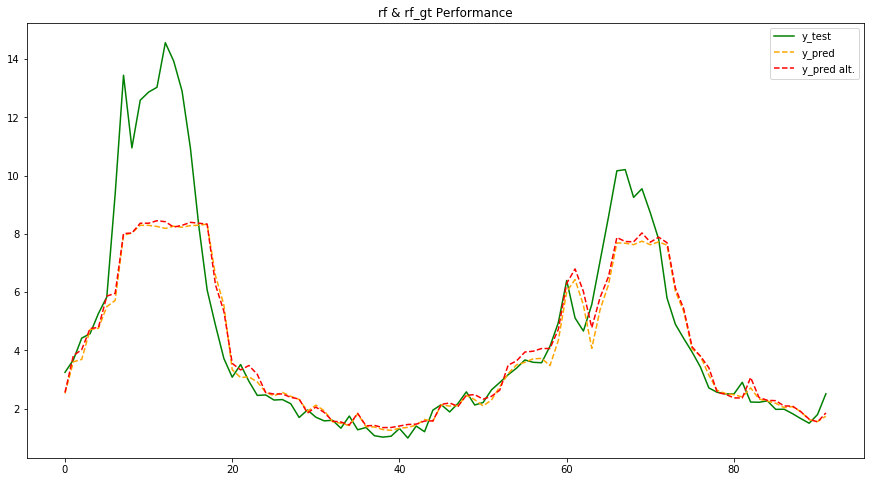

In [66]:
plot_predictions(y_test, 'rf', y_pred, 'rf_gt', y_pred_gt)

In [93]:
importances = rf_gt.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

print("Most important features:")
np.array(X_train_gt_predictors)[indices][:10]

Most important features:


array(['texas_flu', 'New Hampshire', 'Illinois', 'Georgia',
       'District of Columbia', 'Wisconsin', 'Oklahoma', 'Missouri',
       'stomach flu', 'Ohio'], dtype='<U30')

# Vanilla NN

In [117]:
def create_NN(X_train,y_train,batch_size,epochs,verbose):
    n_units = 64
    drop_rate = .2
    optimizer = RMSprop(1e-4)
    loss = "mse"
    batch_size = batch_size
    epochs = epochs
    validation_split = 0.2
    verbose = verbose
    model = tf.keras.Sequential()
    model.add(Dense(input_dim=(X_train.shape[1]),units = n_units,activation = 'relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(units = n_units,activation = 'relu'))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer=optimizer, loss=loss)
    es = EarlyStopping(patience=10)
    model.fit(X_train, y_train,
              batch_size=batch_size, epochs=epochs, 
              validation_split=validation_split,
              verbose=verbose, callbacks=[es])
    return model

Test RMSE:  1.6447725483113655


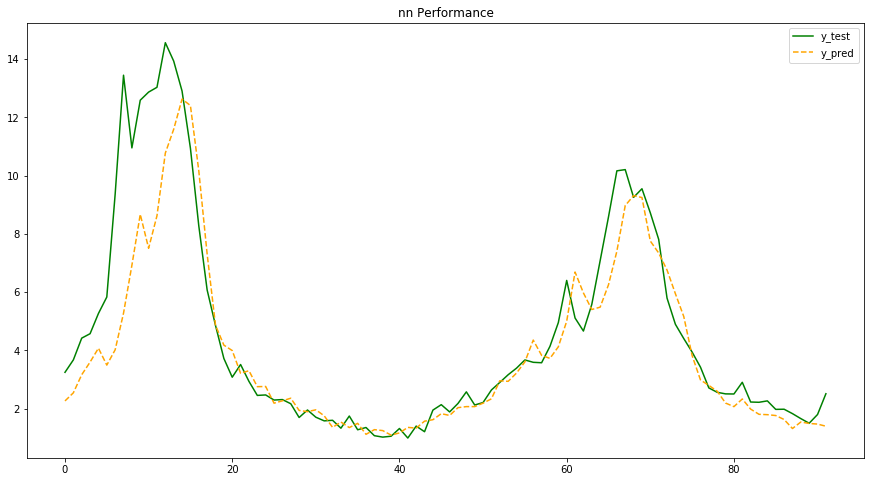

In [121]:
model = create_NN(X_train, y_train,32,100,0)
y_pred = model.predict(X_test)
plot_predictions(y_test, 'nn', y_pred)

Test RMSE:  1.6648902074063265
Test RMSE for alt.:  2.577446294412886


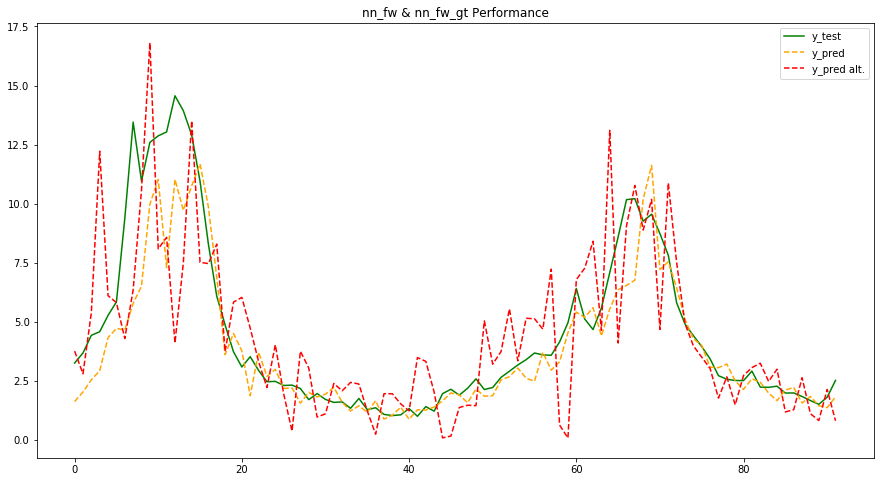

In [122]:
def walk_forward_prediction(model_fn, X_all, X_train, y_all):
    size = len(X_train)
    max_train_size = size
    y_pred = []

    for t in range(len(y_test)):
        X_train_temp, X_test_temp = X_all[size+t-max_train_size:size+t], X_all[size+t:]
        y_train_temp = y_all[size+t-max_train_size:size+t]
        model = model_fn(X_train_temp, y_train_temp,32,50,0)
        pred = model.predict(X_test_temp)
        y_pred.append(pred[0])
    return y_pred

nn_fw_pred = walk_forward_prediction(create_NN, X_all, X_train, y_all)
nn_fw_pred_gt = walk_forward_prediction(create_NN, X_all_gt, X_train_gt, y_all)
plot_predictions(y_test, 'nn_fw',  nn_fw_pred, 'nn_fw_gt',  nn_fw_pred_gt)

In [ ]:
# optimizer = "rmsprop"
# loss = "mae"

# n_steps, n_features = X_train.shape[0], X_train.shape[1]
# n_units = 64
# batch_size = 32
# epochs = 10
# validation_split = 0.2
# verbose = 1

# model = Sequential()
# model.add(SimpleRNN(n_units, activation='relu', input_shape=(n_steps, n_features)))
# model.add(Dense(1, activation='relu'))
          
# # Compile model
# model.compile(optimizer=optimizer, loss=loss)
# print(model.summary())

# # Train model
# history = model.fit(X_train.reshape(1,X_train.shape[0],X_train.shape[1]),
#                     y_train.reshape(1,y_train.shape[0]),
#                     batch_size=batch_size, epochs=epochs, 
#                     validation_split=validation_split, verbose=verbose)